### **Automated Customer Complaints Classification Leveraging NLP and Machinne Learning.**

#### **Introduction:**
In today's fast-paced and ever evolving world, businesses strive to provide excellent customer service to stand out and retain their customer base. One of the critical aspect of any business is customer service, making sure that, the businesses are efficiently handling customer complaints. The rapid advancements in technology have changed the way businesses handle customer support, with automated complaint classification systems emerging as a major tool. These systems, powered by sophisticated machine learning algorithms and artificial intelligence, enable companies to efficiently categorize and address customer grievances, significantly improving response times, service quality and streamlining the resolution process.

#### **Dataset Description**

The dataset we are using for this task, is a collection of complaint tickets from a financial institution, stored in JSON format. This dataset serves as a rich repository of textual data, reflecting a large number of issues and interactions between customers and the institution. These texts are customer-initiated complaints or queries related to different financial products and services offered by the institution. The data shows what customers complain about and how happy they are with financial services. It helps understand what problems the company faces and how satisfied customers are.

##### **Data Structure and Attributes**
Each record in the dataset represents a single complaint, encapsulated in a structured format with multiple fields. Key attributes include:
- **_index and _type**: These fields denote the index and type of the data source, respectively, typically signifying the internal database or category of complaints within the institution.

- **_id**: A unique identifier for each complaint, facilitating easy retrieval and reference.
- **_score**: This could represent a relevance or priority score assigned to the complaint, although it appears uniformly set to 0.0 in the sample, suggesting it may not be actively used or is placeholder data.
- **_source.tags**: Tags or labels that may have been applied to categorize the complaint, such as 'Servicemember' in one of the entries, indicating specific customer segments or issues.
- **_source.zip_code**: The postal code of the complainant, providing geographical context and allowing for regional analysis of complaint patterns.
- **_source.complaint_id**: Another unique identifier for the complaint, likely used for internal tracking and management.
- **_source.issue**: A brief description of the complaint or the primary issue raised by the customer.
- **_source.date_received**: The date and time when the complaint was filed, crucial for understanding the temporal distribution of complaints.
- **_source.state**: The state from which the complaint originated, further adding to the geographical analysis capability.
- Additional fields capturing the company's response, the medium through which the complaint was submitted, and detailed descriptions of the complaint.

**USE CASES OF DATA**
- Customer Service Improvement: Identifying common complaint themes can help the institution address systemic issues and improve customer service quality.
- Product and Service Enhancement: Analysis of complaint patterns can guide product development and service enhancements, aligning offerings more closely with customer needs.
- Risk Management: Understanding the nature and frequency of complaints related to fraud and disputes can aid in refining risk management strategies and fraud prevention mechanisms.
- Market and Regional Analysis: Geographical data points allow for regional analysis of complaints, helping to identify market-specific issues or opportunities for targeted interventions.

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# import modules
import json  # load json
import numpy as np  # numerical ops
import pandas as pd  # data manipulation
import re  # text process
import nltk  # text process
import spacy  # text process
import string  # text process
import unicodedata  # unicode ops
import warnings  # warnings
import seaborn as sns  # plotting
import matplotlib.pyplot as plt  # plotting
from wordcloud import WordCloud, STOPWORDS  # word cloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer  # text features
from sklearn.decomposition import NMF  # matrix factor
from pprint import pprint  # pretty print
from tqdm import tqdm  # progress bar
from sklearn.model_selection import train_test_split  # data split
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # metrics
from sklearn.preprocessing import label_binarize  # label binarize
from sklearn.multiclass import OneVsRestClassifier  # multiclass
from xgboost import XGBClassifier  # xgboost
from itertools import cycle  # cycle iter
import itertools  # itertools
import gensim
from gensim.models import Nmf  # gensim nmf
from gensim.models.coherencemodel import CoherenceModel  # coherence model
from gensim.corpora import Dictionary  # gensim dict

In [ ]:
# config settings
warnings.filterwarnings('ignore')  #ignore warnings
pd.set_option('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None)  #pandas config
tqdm.pandas()  # progress apply

In [ ]:
# initialize spacy
nlp = spacy.load('en_core_web_sm')  # load model

Load Data

In [ ]:
json_file_path = "complaints.json"

with open(json_file_path, "r") as json_file:
    complaints_data = json.load(json_file)
    complaints_df = pd.json_normalize(complaints_data)

complaints_df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state _source.consumer_disputed  \
0  2019-04-13T12:00:00-05:00            CA                       N/A   
1  2019-05-01T12:00:00-05:00            GA                       N/A   
2  2019-04-02T12:00:00-05:00            TX                       N/A   
3  2017-09-13T12:00:00-05:00            MI                       N/A   
4  2019-04-05T12:00:00-05:00            NY                       N/A   

               _source.product _source.company_response       _source.company  \
0              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
1              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
2  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   
3                     Mortgage  Closed with explanation  JPMORGAN CHASE & CO.   
4  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   

  _source.submitted_via _source.date_sent_to_company  \
0                   Web    2019-04-13T12:00:00-05:00   
1                   Web    2019-05-01T12:00:00-05:00   
2                   Web    2019-04-02T12:00:00-05:00   
3                   Web    2017-09-14T12:00:00-05:00   
4              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely  \
0            Yes   
1            Yes   
2            Yes   
3            Yes   
4            Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              _source.complaint_what_happened  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to vali

Data Exploartion and Preparation

In [ ]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
complaints_df.describe()

_score
count  78313.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

In [ ]:
complaints_df.describe(include='object').T

count unique  \
_index                             78313      1   
_type                              78313      1   
_id                                78313  78313   
_source.tags                       10900      3   
_source.zip_code                   71556   9442   
_source.complaint_id               78313  78313   
_source.issue                      78313    154   
_source.date_received              78313   3444   
_source.state                      76322     62   
_source.consumer_disputed          78313      3   
_source.product                    78313     17   
_source.company_response           78313      8   
_source.company                    78313      1   
_source.submitted_via              78313      6   
_source.date_sent_to_company       78313   3309   
_source.company_public_response        4      3   
_source.sub_product                67742     72   
_source.timely                     78313      2   
_source.complaint_what_happened    78313  20931   
_source.sub_issue                  32016    205   
_source.consumer_consent_provided  77305      5   

                                                                                                                               top  \
_index                                                                                                         complaint-public-v2   
_type                                                                                                                    complaint   
_id                                                                                                                        3211475   
_source.tags                                                                                                        Older American   
_source.zip_code                                                                                                             606XX   
_source.complaint_id                                                                                                       3211475   
_source.issue                                                                             Loan modification,collection,foreclosure   
_source.date_received                                                                                    2015-08-27T12:00:00-05:00   
_source.state                                                                                                                   CA   
_source.consumer_disputed                                                                                                      N/A   
_source.product                                                                                                           Mortgage   
_source.company_response                                                                                   Closed with explanation   
_source.company                                                                                               JPMORGAN CHASE & CO.   
_source.submitted_via                                                                                                          Web   
_source.date_sent_to_company                                                                             2012-06-21T12:00:00-05:00   
_source.company_public_response    Company has responded to the consumer and the CFPB and chooses not to provide a public response   
_source.sub_product                                                                                               Checking account   
_source.timely                                                                                                                 Yes   
_source.complaint_what_happened                                                                                                      
_source.sub_issue                                 Credit card company isn't resolving a dispute about a purchase on your statement   
_source.consumer_consent_provided                                                                 

In [ ]:
complaints_df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
def rename_columns(column_name):
    if column_name.startswith('_source.'):
        return column_name[len('_source.'):]
    elif column_name.startswith('_'):
        return column_name[1:]  # remove leading underscore
    return column_name
complaints_df.columns = [rename_columns(col) for col in complaints_df.columns]
complaints_df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
#filter out rows where 'complaint_what_happened' is either blank or NaN
complaints_df = complaints_df[complaints_df['complaint_what_happened'].replace('', np.nan).notnull()]

In [ ]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


Complaints Over Time Analysis

In [ ]:
complaints_df['date_received'] = pd.to_datetime(complaints_df['date_received'])
min_date = complaints_df['date_received'].min()
print(f"Minimum date: {min_date}")
# Find the maximum date
max_date = complaints_df['date_received'].max()
print(f"Maximum date: {max_date}")

Minimum date: 2015-03-19 12:00:00-05:00
Maximum date: 2021-03-14 12:00:00-05:00


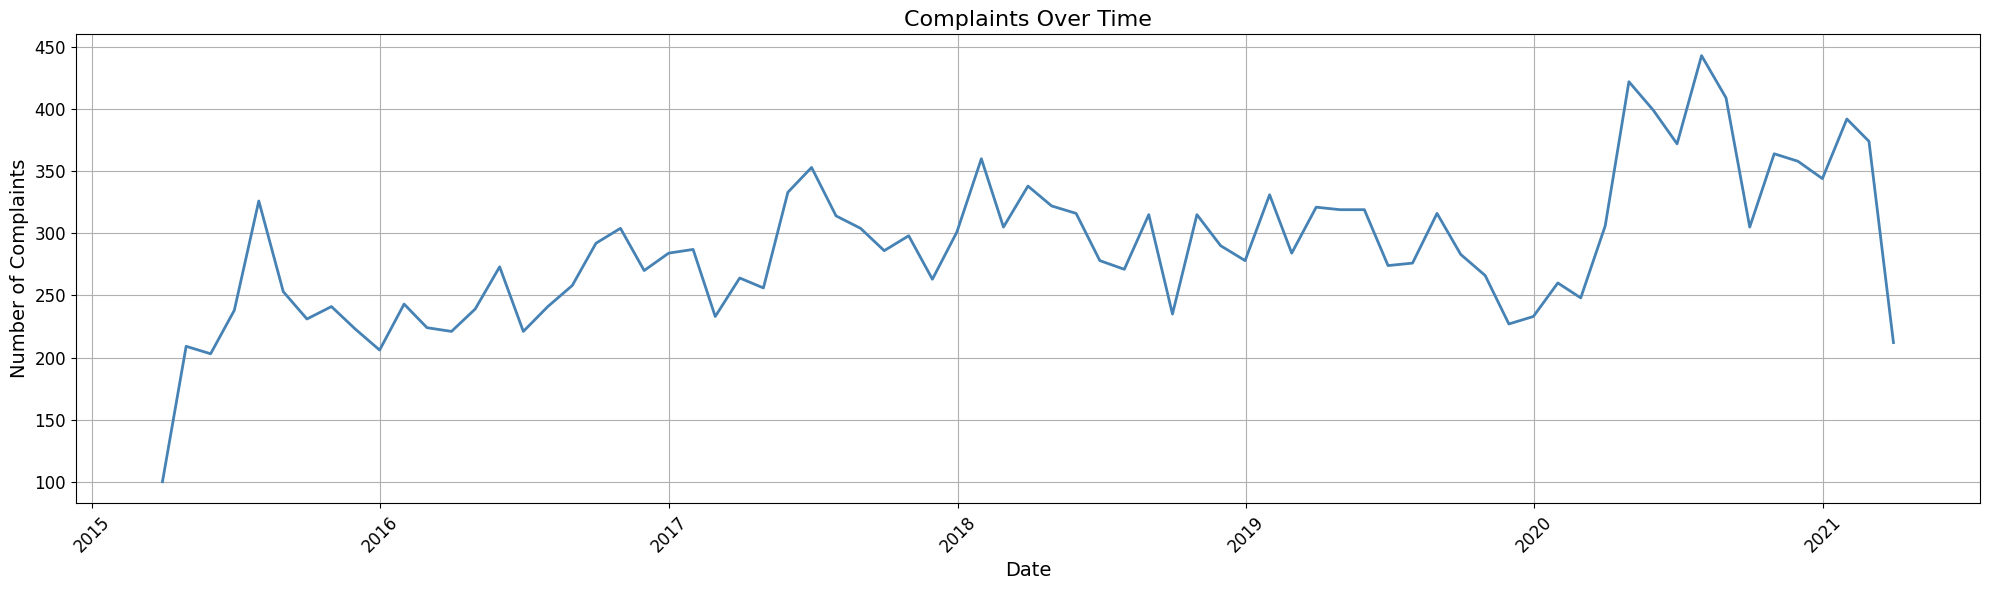

In [ ]:

monthly_complaints = complaints_df.set_index('date_received').resample('M').size()

plt.figure(figsize=(20, 6))
plt.plot(monthly_complaints.index, monthly_complaints, color='steelblue', linestyle='-', linewidth=2)

plt.title('Complaints Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

plt.grid(True)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

Complaints by State

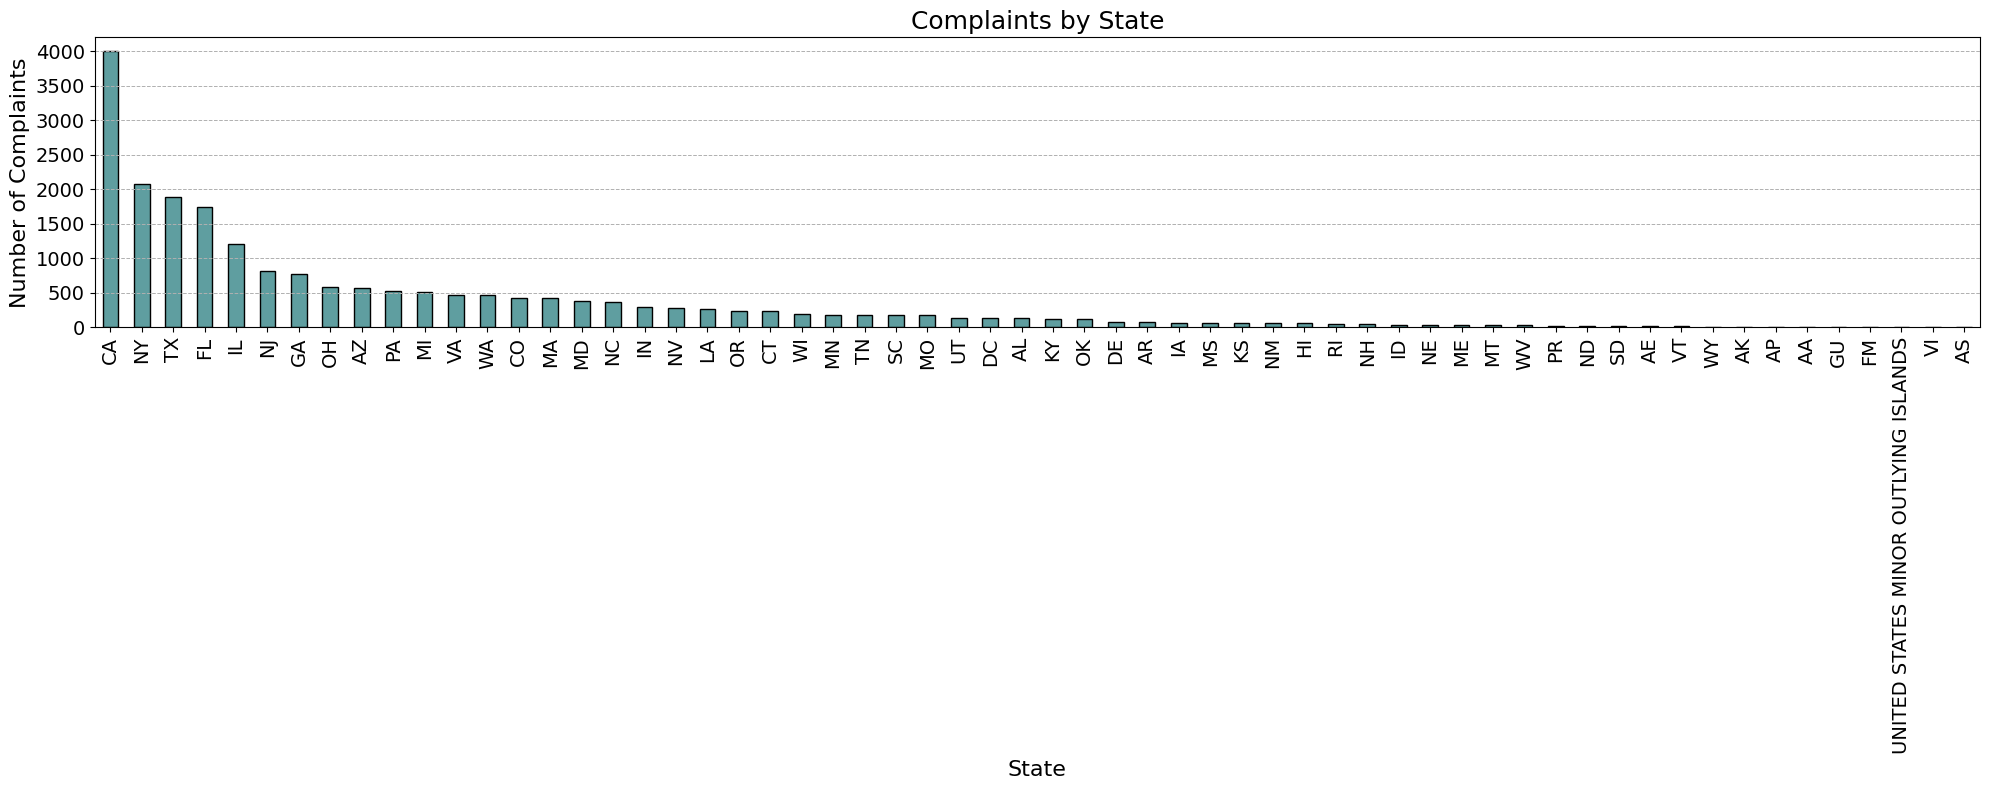

In [ ]:
state_complaints = complaints_df['state'].value_counts()

plt.figure(figsize=(20, 8))
state_complaints.plot(kind='bar', color='cadetblue', edgecolor='black')
plt.title('Complaints by State', fontsize=18)
plt.xlabel('State', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Complaint by Issue

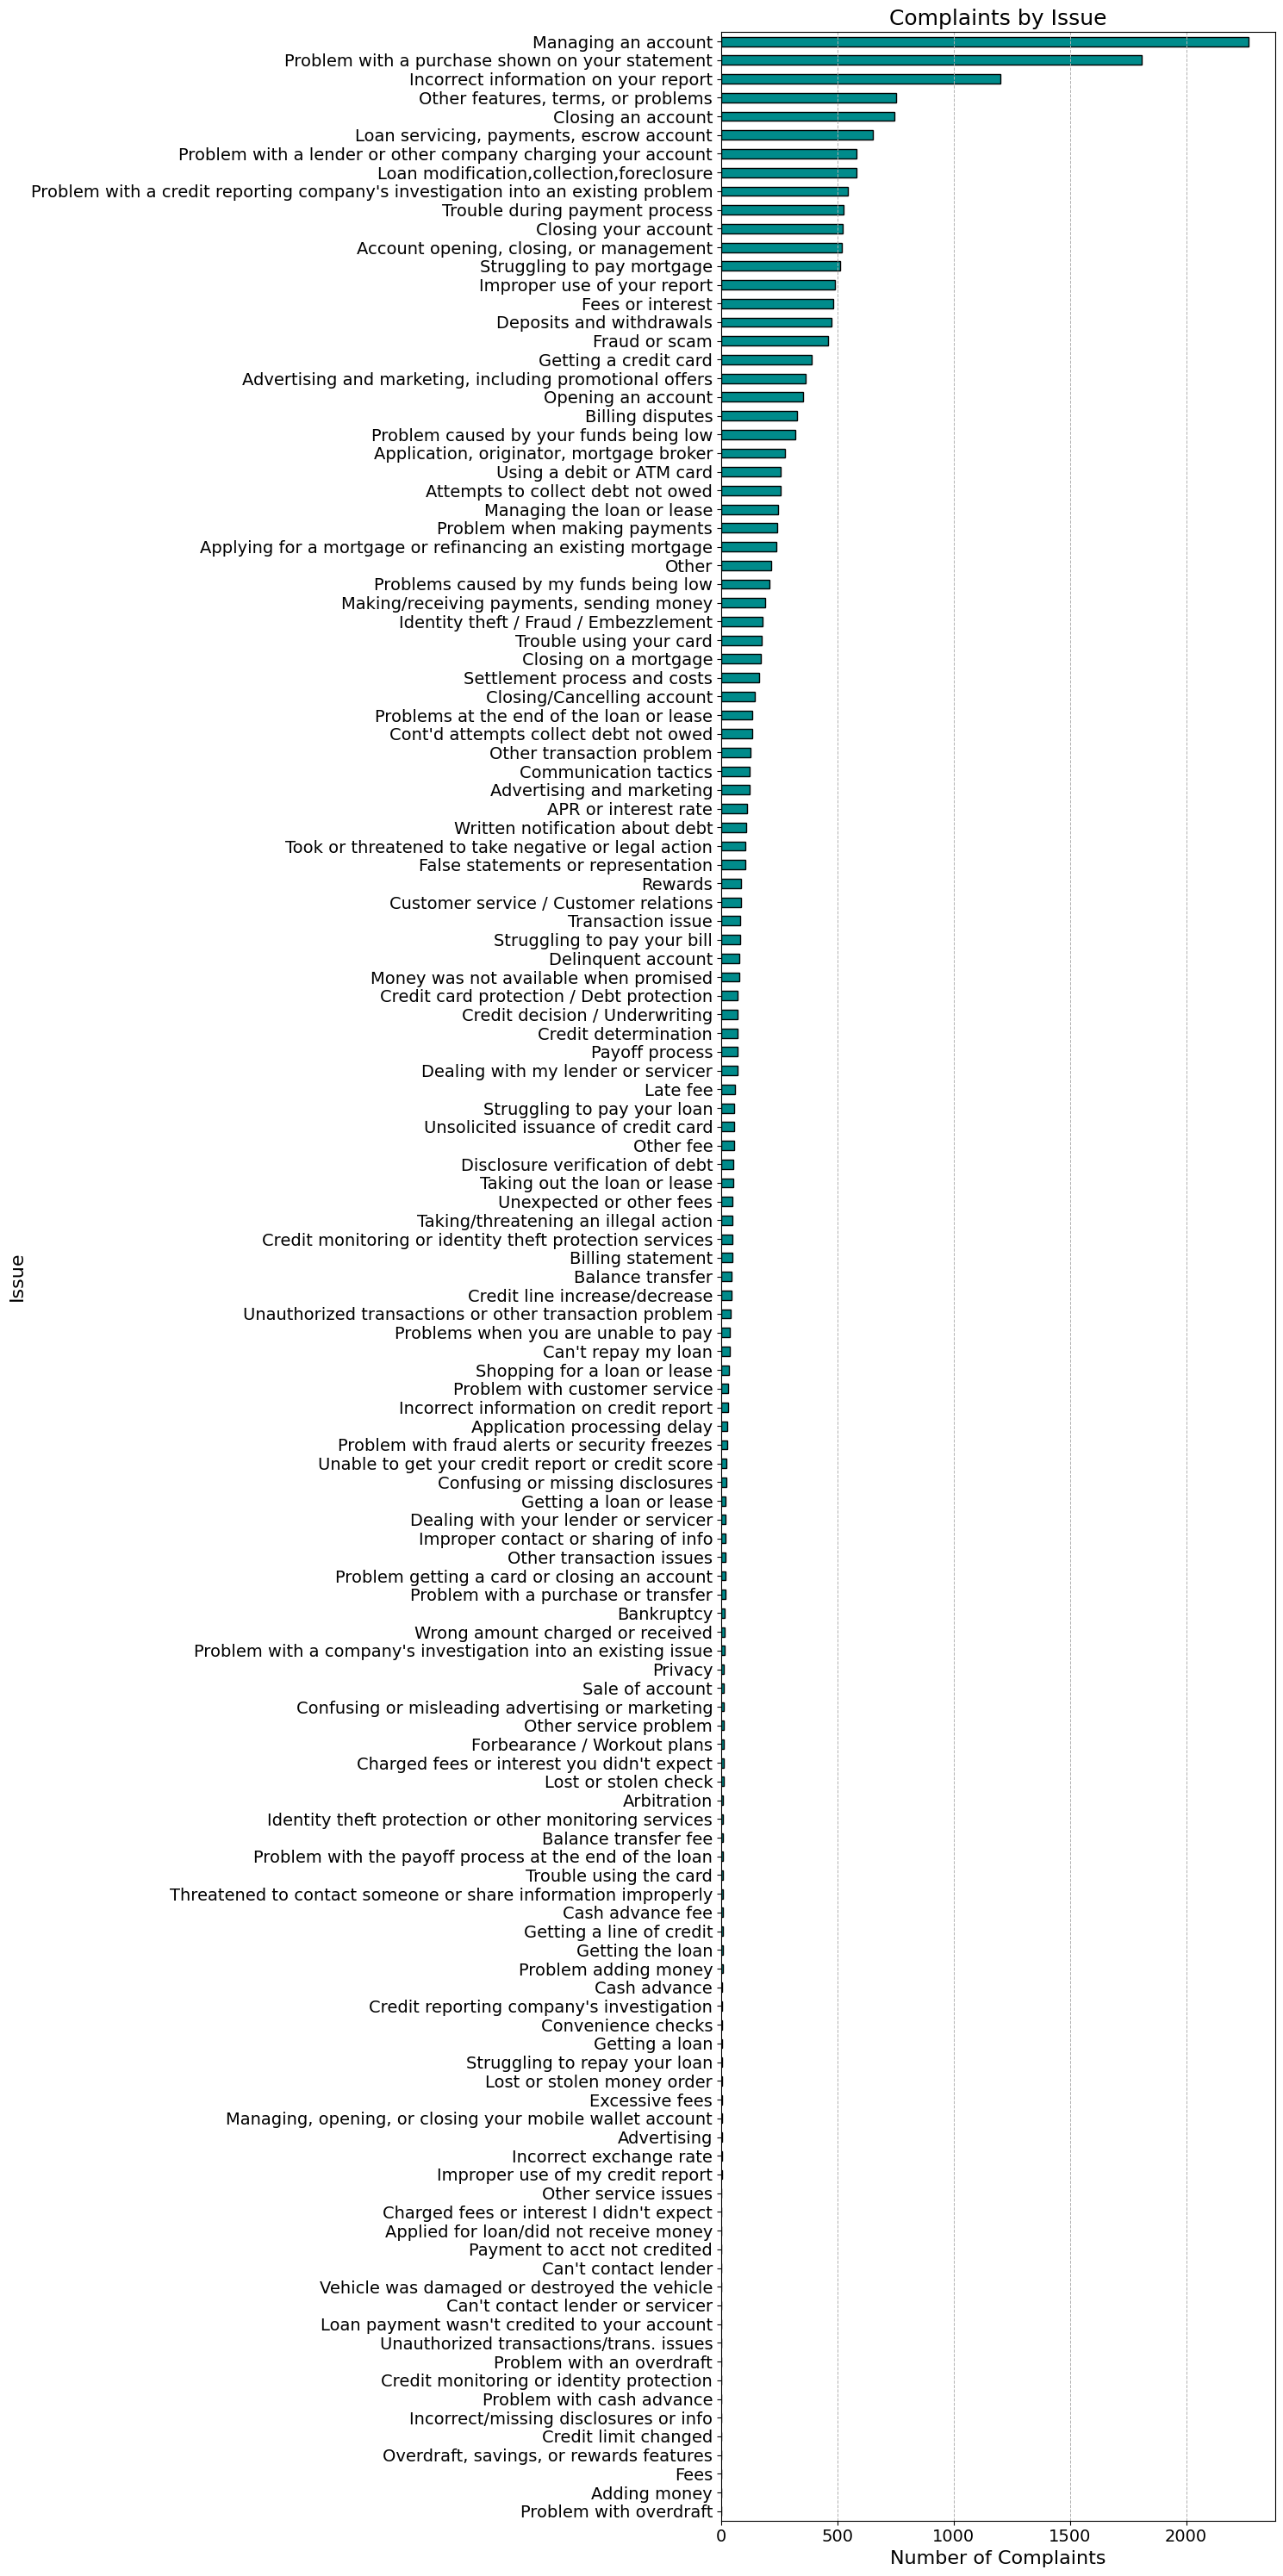

In [ ]:
# Calculate the number of complaints per issue
issue_complaints = complaints_df['issue'].value_counts()
plt.figure(figsize=(15, 30))
issue_complaints.plot(kind='barh', color='darkcyan', edgecolor='black')
plt.title('Complaints by Issue', fontsize=18)
plt.xlabel('Number of Complaints', fontsize=16)
plt.ylabel('Issue', fontsize=16)

plt.grid(axis='x', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Complaints by Company Response

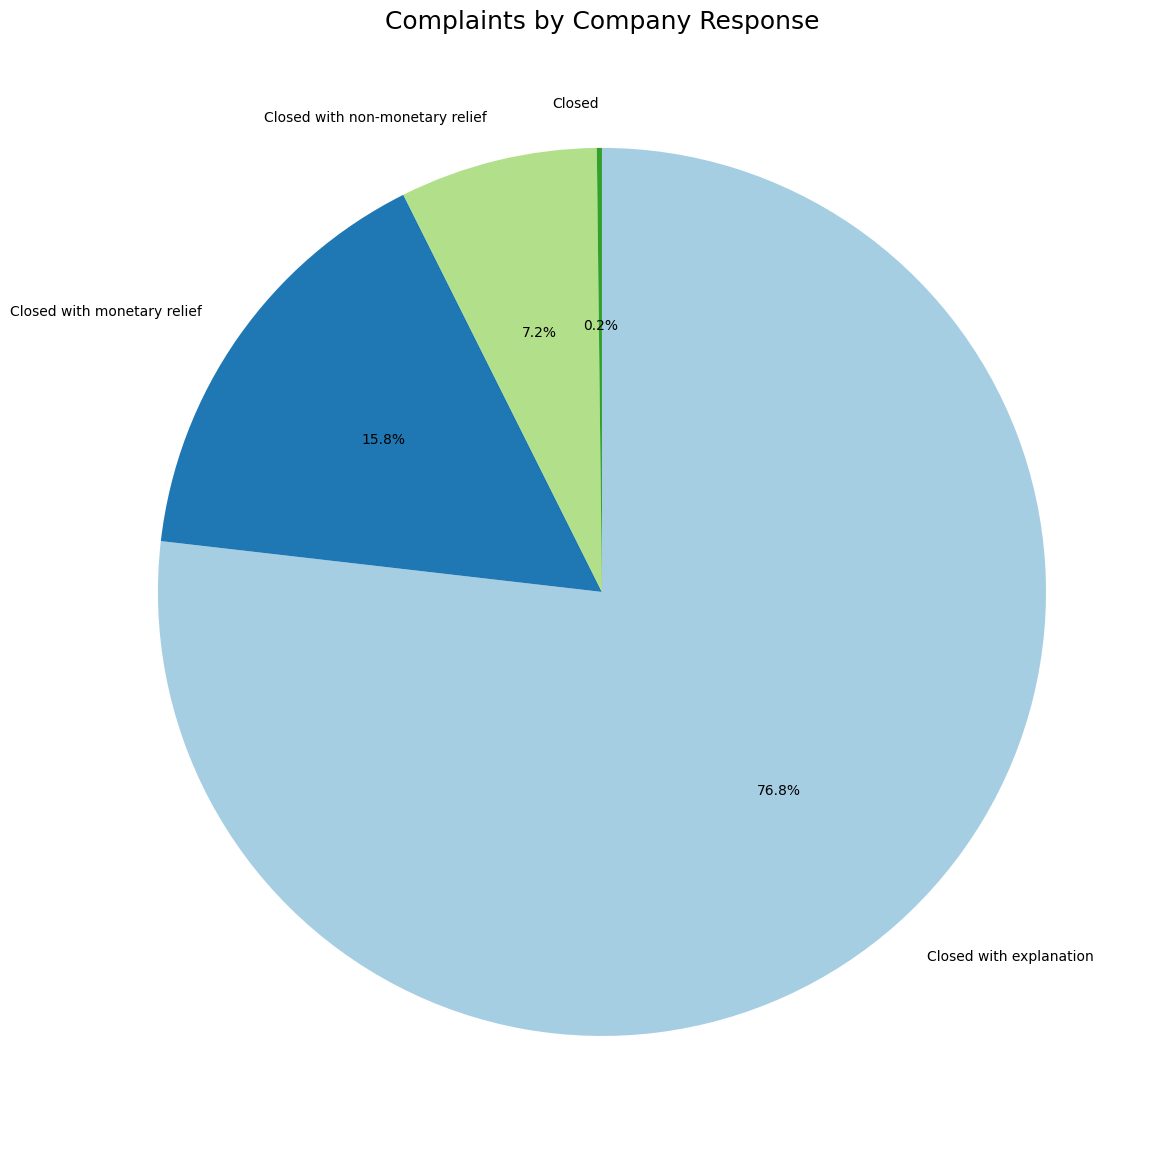

In [ ]:
company_response_counts = complaints_df['company_response'].value_counts()

plt.figure(figsize=(12, 12))
colors = plt.cm.Paired(range(len(company_response_counts)))
company_response_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Complaints by Company Response', fontsize=18)
plt.ylabel('')
plt.tight_layout()
plt.show()

Complaints by Product

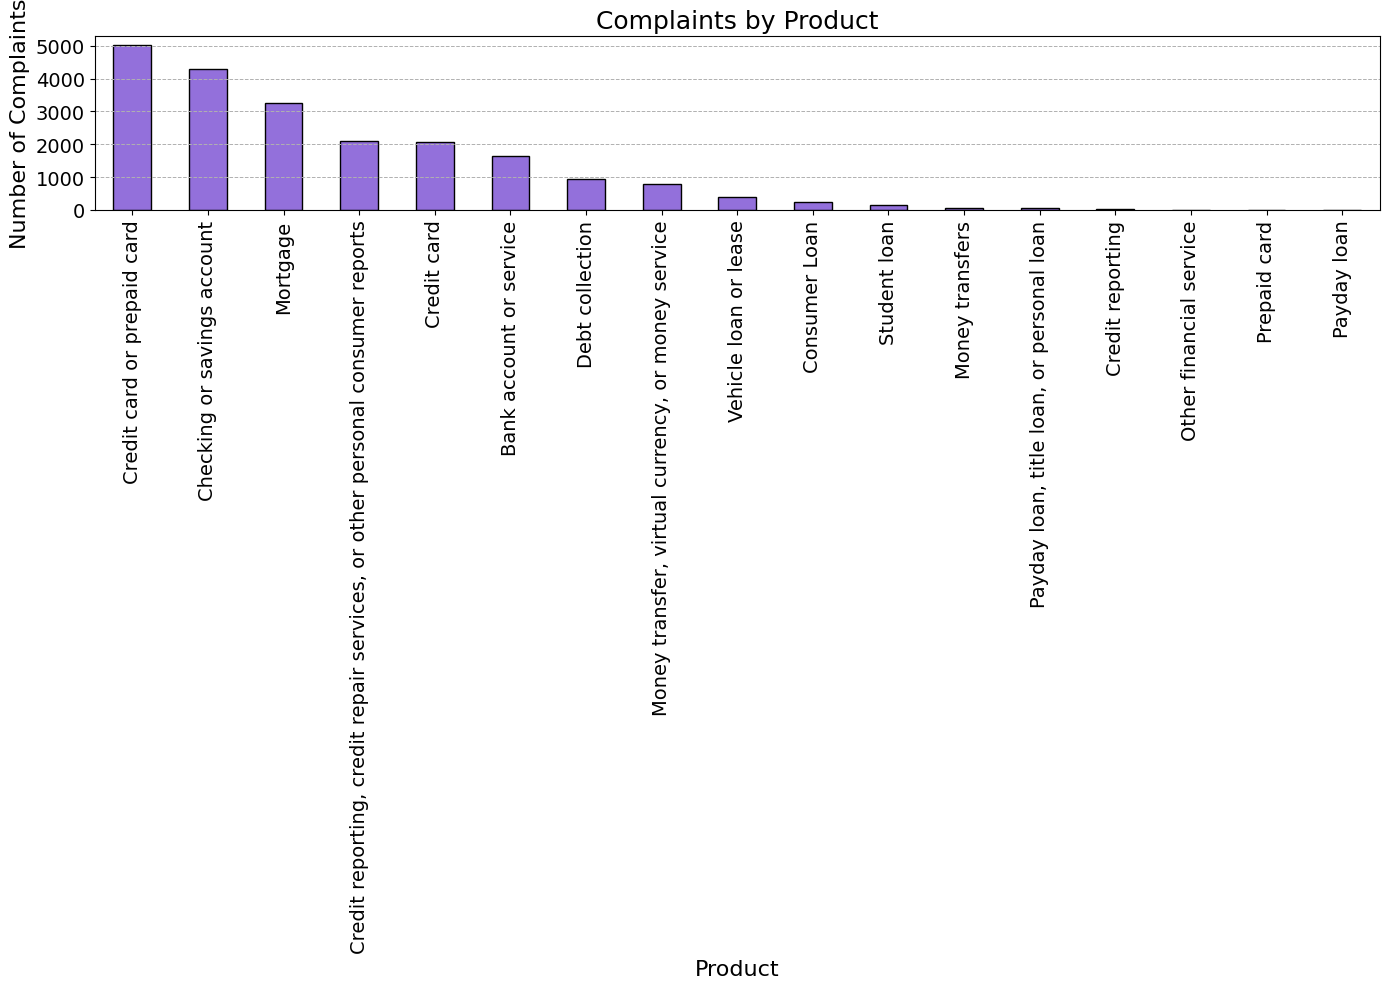

In [ ]:
product_complaints = complaints_df['product'].value_counts()

plt.figure(figsize=(14, 10))
product_complaints.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title('Complaints by Product', fontsize=18)
plt.xlabel('Product', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

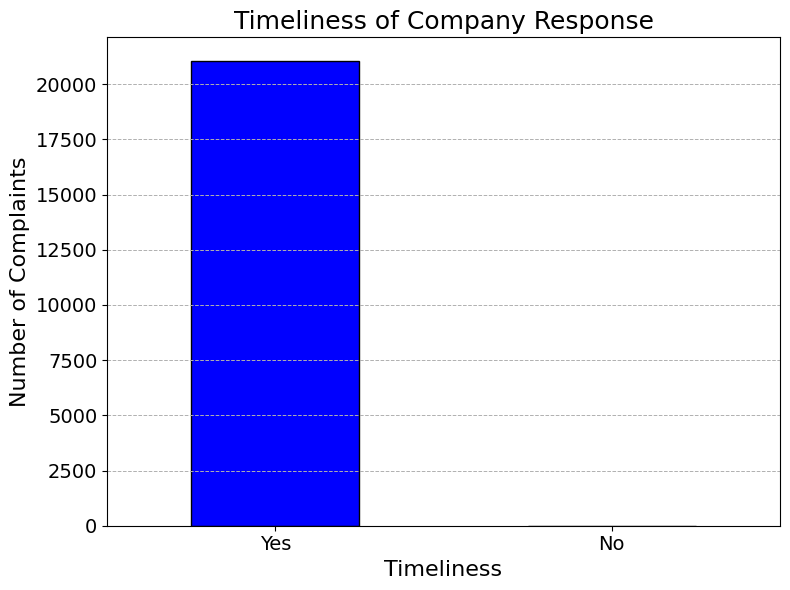

In [ ]:
timely_counts = complaints_df['timely'].value_counts()
plt.figure(figsize=(8, 6))
timely_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Timeliness of Company Response', fontsize=18)
plt.xlabel('Timeliness', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

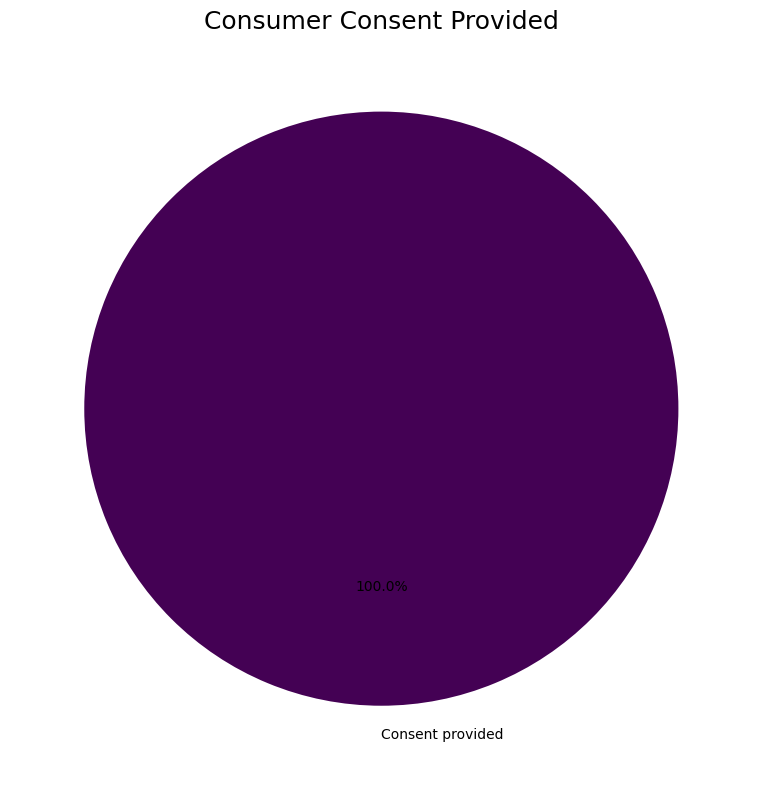

In [ ]:
consent_counts = complaints_df['consumer_consent_provided'].value_counts()
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(range(len(consent_counts)))
consent_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Consumer Consent Provided', fontsize=18)
plt.ylabel('')

plt.tight_layout()
plt.show()

#### **Data Preparation**


In [ ]:
def preprocess_text(text):
    """
    Preprocesses the text by converting to lowercase, removing text within square brackets,
    eliminating punctuation, and discarding words with numbers.
    """
    text = text.lower()
    text = re.sub(r'\[.*?]', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\w*\d\w*', ' ', text)
    return text.strip()

def apply_lemmatization(text_list):
    """
    Applies lemmatization to a list of text strings, excluding stopwords and punctuation.
    """
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(text_list), total=len(text_list)):
        lemmatized_texts.append(' '.join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct))
    return lemmatized_texts

def filter_nouns(text_list):
    """
    Filters and returns only the nouns from a list of text strings.
    """
    noun_texts = []
    for doc in tqdm(nlp.pipe(text_list), total=len(text_list)):
        noun_texts.append(' '.join(token.text for token in doc if token.pos_ == 'NOUN'))
    return noun_texts

In [ ]:
processed_df = pd.DataFrame()

# Preprocess the text data
processed_df['complaint_processed'] = [preprocess_text(text) for text in tqdm(complaints_df['complaint_what_happened'])]

100%|██████████| 21072/21072 [00:13<00:00, 1515.12it/s]


In [ ]:
# Apply lemmatization on the processed text
processed_df['complaint_lemmatized'] = apply_lemmatization(processed_df['complaint_processed'])

100%|██████████| 21072/21072 [13:02<00:00, 26.92it/s]


In [ ]:
# Filter nouns from the lemmatized text
processed_df['complaint_nouns'] = filter_nouns(processed_df['complaint_lemmatized'])

100%|██████████| 21072/21072 [06:27<00:00, 54.37it/s]


In [ ]:
# Display the initial rows of the processed dataframe
processed_df.head()

complaint_processed  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services  \nin   i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable  i am asking the bank to validate the debt  instead i been receiving mail every month from them attempting to collect a debt  \ni have a right to know this information as a consumer  \n\nchase account   xxxx xxxx xxxx xxxx thanks in advance for your help   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       i upgraded my xxxx xxxx card in xx xx   and was told by the agent who did the upgrade my anniversary date would not change  it turned the agent was giving me the wrong information in order to upgrade the account  xxxx   changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent  xxxx has the recording of the agent who was misled me   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

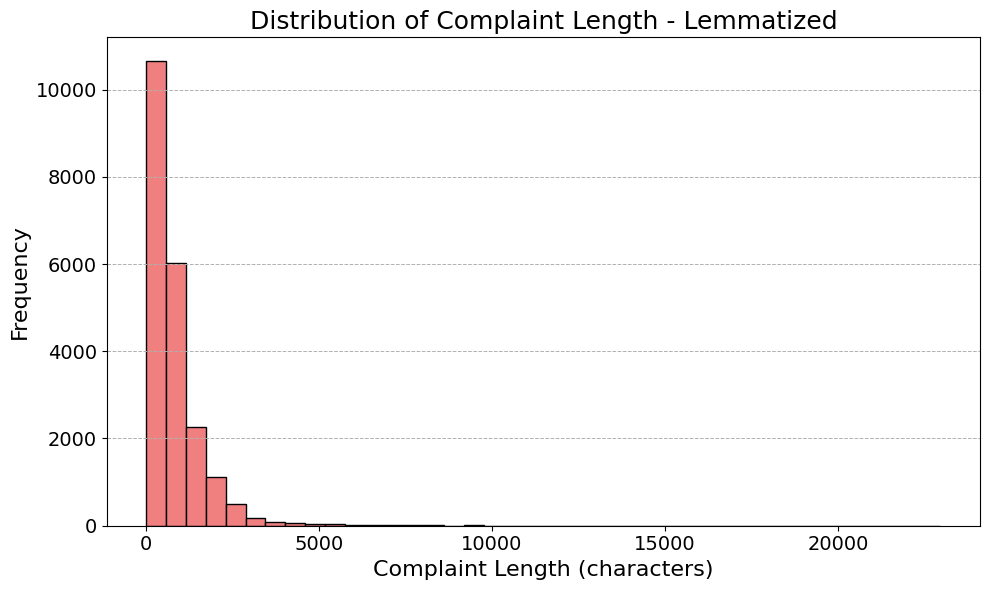

In [ ]:
complaint_length = processed_df['complaint_lemmatized'].str.len()
plt.figure(figsize=(10, 6))
complaint_length.plot(kind='hist', bins=40, color='lightcoral', edgecolor='black')
plt.title('Distribution of Complaint Length - Lemmatized', fontsize=18)
plt.xlabel('Complaint Length (characters)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

**Word Cloud**

In [ ]:
all_nouns = ' '.join(processed_df['complaint_nouns'])

wordcloud = WordCloud(max_words=50, background_color='white', colormap='viridis',
                      contour_color='steelblue', contour_width=2).generate(all_nouns)


In [ ]:
#print the top 70 words
top_50_words = list(wordcloud.words_.keys())[:50]
print(top_50_words)

['credit card', 'xxxx', 'chase', 'time', 'bank', 'information', 'state', 'day', 'xxxx xxxx', 'account', 'transaction', 'request', 'credit report', 'issue', 'month', 'year', 'money', 'contact', 'chase credit', 'company', 'work', 'customer service', 'call chase', 'week', 'account chase', 'claim', 'person', 'reason', 'way', 'chase bank', 'process', 'order', 'check account', 'document', 'fact', 'point', 'situation', 'today', 'change', 'contact chase', 'fraud', 'place', 't', 'problem', 'fee', 'pay', 'notice', 'letter', 'help', 'debit card']


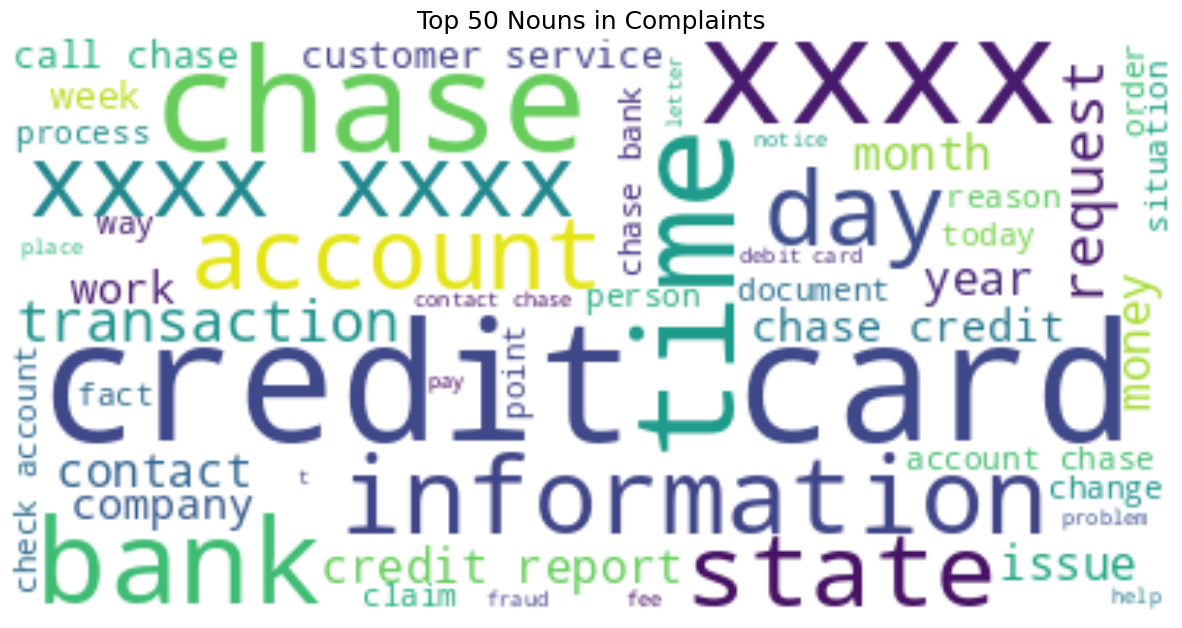

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top 50 Nouns in Complaints', fontsize=18)
plt.axis('off')
plt.show()

In [ ]:
processed_df['complaint_cleaned'] = processed_df['complaint_nouns'].apply(lambda x: x.replace('-PRON-', ''))

Top 30 unigram frequency among the complaints

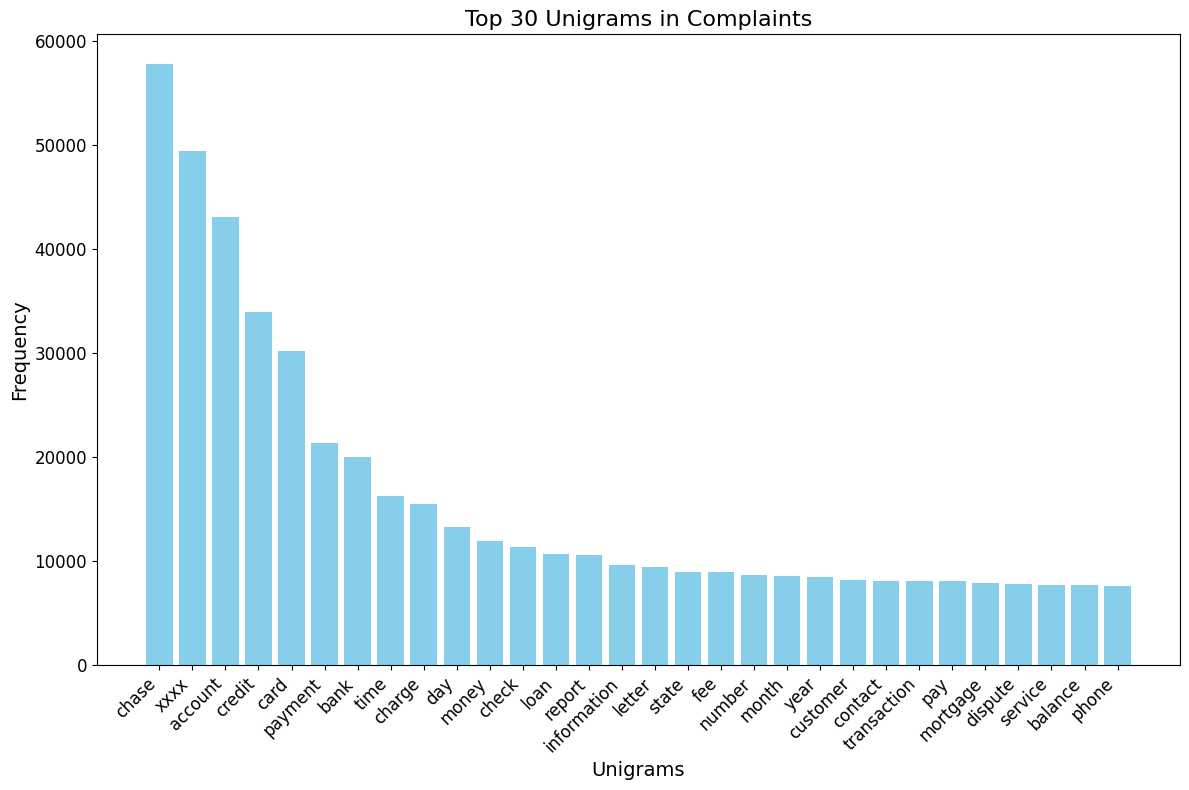

In [ ]:
all_complaints = ' '.join(processed_df['complaint_cleaned'])

# Function to get the top n words by frequency
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 30 unigrams
common_unigrams = get_top_n_words([all_complaints], 30)
df_unigram = pd.DataFrame(common_unigrams, columns=['unigram', 'count'])

# Plotting the top 30 unigrams using matplotlib
plt.figure(figsize=(12, 8))
plt.bar(df_unigram['unigram'], df_unigram['count'], color='skyblue')
plt.xlabel('Unigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 30 Unigrams in Complaints', fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

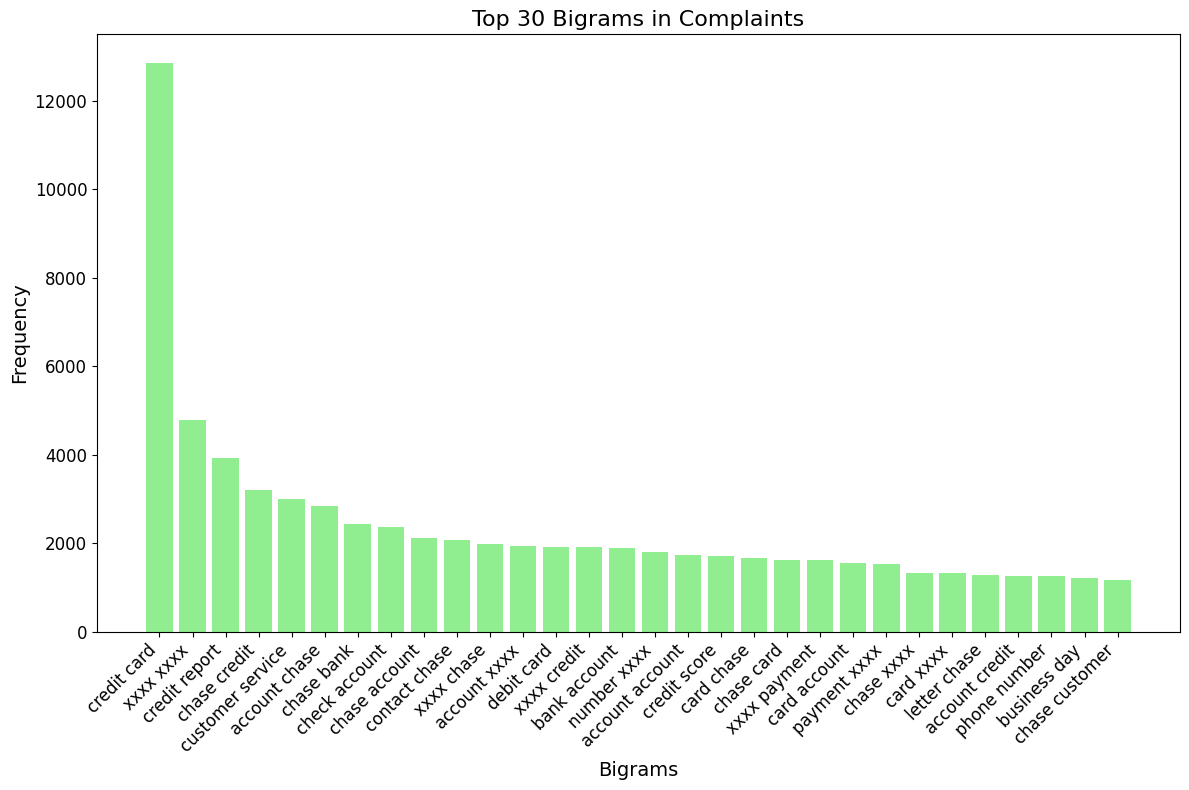

In [ ]:
# Function to get the top n bigrams by frequency
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 30 bigrams
common_bigrams = get_top_n_bigram([all_complaints], 30)
df_bigram = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

# Plotting the top 30 bigrams using matplotlib
plt.figure(figsize=(12, 8))
plt.bar(df_bigram['bigram'], df_bigram['count'], color='lightgreen')
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 30 Bigrams in Complaints', fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

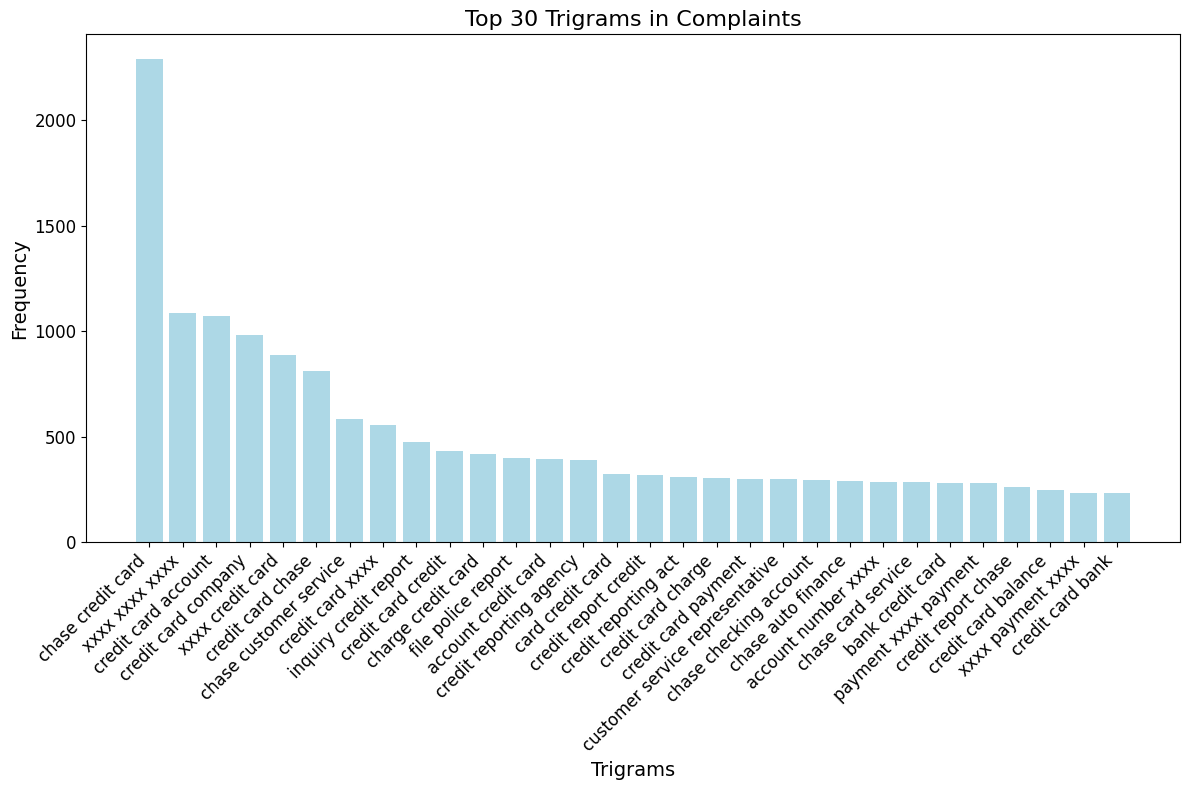

In [ ]:
# Function to get the top n trigrams by frequency
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 30 trigrams
common_trigrams = get_top_n_trigram([all_complaints], 30)
df_trigram = pd.DataFrame(common_trigrams, columns=['trigram', 'count'])

# Plotting the top 30 trigrams using matplotlib
plt.figure(figsize=(12, 8))
plt.bar(df_trigram['trigram'], df_trigram['count'], color='lightblue')
plt.xlabel('Trigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 30 Trigrams in Complaints', fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

removing 'xxxx xxxx' masked credentials from the data

In [ ]:
processed_df['complaint_cleaned'] = processed_df['complaint_cleaned'].str.replace('xxxx', '')


In [ ]:
all_complaints = ' '.join(processed_df['complaint_cleaned'])
wordcloud_complaints = WordCloud(max_words=50, background_color='white', colormap='viridis',
                      contour_color='steelblue', contour_width=2).generate(all_complaints)

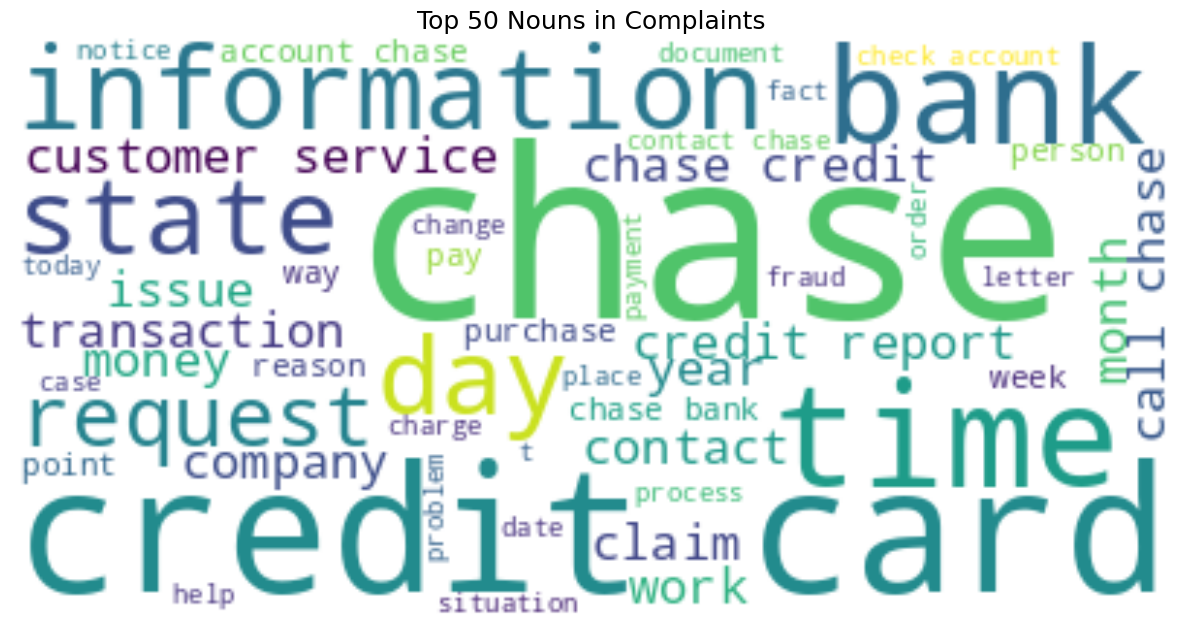

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_complaints, interpolation='bilinear')
plt.title('Top 50 Nouns in Complaints', fontsize=18)
plt.axis('off')
plt.show()

Texts to a matrix of TF-IDF features

In [ ]:
tfidf_vect = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

# create Document Term Matrix by transforming the "complaint_cleaned"
X = tfidf_vect.fit_transform(processed_df['complaint_cleaned'])

In [ ]:
# Document Term Matrix
dtm_df = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names_out())
dtm_df.head()

aaa  aarp  abandon  abandonment  abate  abatement  abbreviation  abd  \
0  0.0   0.0      0.0          0.0    0.0        0.0           0.0  0.0   
1  0.0   0.0      0.0          0.0    0.0        0.0           0.0  0.0   
2  0.0   0.0      0.0          0.0    0.0        0.0           0.0  0.0   
3  0.0   0.0      0.0          0.0    0.0        0.0           0.0  0.0   
4  0.0   0.0      0.0          0.0    0.0        0.0           0.0  0.0   

   abhorrent  abide  ability  abovementione  abscond  absence  absent  \
0        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
1        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
2        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
3        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
4        0.0    0.0      0.0            0.0      0.0      0.0     0.0   

   absolve  absorb  absurdity  abundance  abuse  abuser  abusive   ac  \
0      0.0     0.0        0.0        0.0    0.0     0.0      0.0  0.0   
1      0.0     0.0        0.0        0.0    0.0     0.0      0.0  0.0   
2      0.0     0.0        0.0        0.0    0.0     0.0      0.0  0.0   
3      0.0     0.0        0.0        0.0    0.0     0.0      0.0  0.0   
4      0.0     0.0        0.0        0.0    0.0     0.0      0.0  0.0   

   accelerate  acceleration  accent  accept  acceptance  access  \
0         0.0           0.0     0.0     0.0         0.0     0.0   
1         0.0           0.0     0.0     0.0         0.0     0.0   
2         0.0           0.0     0.0     0.0         0.0     0.0   
3         0.0           0.0     0.0     0.0         0.0     0.0   
4         0.0           0.0     0.0     0.0         0.0     0.0   

   accessibility  accessory  accident  accommodate  accommodation  \
0            0.0        0.0       0.0          0.0            0.0   
1            0.0        0.0       0.0          0.0            0.0   
2            0.0        0.0       0.0          0.0            0.0   
3            0.0        0.0       0.0          0.0            0.0   
4            0.0        0.0       0.0          0.0            0.0   

   accomodation  accompany  accomplish  accont  accord  accordance  accou  \
0           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
1           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
2           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
3           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
4           0.0        0.0         0.0     0.0     0.0         0.0    0.0   

   accouint  accoun  accound   account  accountability  accountant  \
0       0.0     0.0      0.0  0.092284             0.0         0.0   
1       0.0     0.0      0.0  0.061131             0.0         0.0   
2       0.0     0.0      0.0  0.000000             0.0         0.0   
3       0.0     0.0      0.0  0.127371             0.0         0.0   
4       0.0     0.0      0.0  0.138876             0.0         0.0   

   accountholder  accounting  accout  accredit  acct  accumulate  \
0            0.0         0.0     0.0       0.0   0.0         0.0   
1            0.0         0.0     0.0       0.0   0.0         0.0   
2            0.0         0.0     0.0       0.0   0.0         0.0   
3            0.0         0.0     0.0       0.0   0.0         0.0   
4            0.0         0.0     0.0       0.0   0.0         0.0   

   accumulation  accunt  accuracy  accurateness  accure  accusation  accuse  \
0           0.0     0.0       0.0           0.0     0.0         0.0     0.0   
1           0.0     0.0       0.0           0.0     0.0         0.0     0.0   
2           0.0     0.0       0.0           0.0     0.0         0.0     0.0   
3           0.0     0.0       0.0           0.0     0.0         0.0     0.0   
4           0.0     0.0       0.0           0.0     0.0         0.0     0.0   

   ach  achieve  acion  acivity  ack  acknowledge  acknowledgement  \
0  0.0      0.0   

**Topic Modelling**

Non-Negative Matrix Factorization (NMF) is an unsupervised technique used for topic modeling. Unlike supervised methods, NMF does not require predefined topic labels for training. Instead, it decomposes high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors have non-negative coefficients, aiding in the interpretation of topics.

- Determine the optimal number of clusters.
- Utilize the optimal number to generate word clusters.
- Evaluate and validate the relevance of each cluster concerning the given complaints.
- Adjust cluster labels if necessary.
- Associate clusters with specific topics or cluster names for interpretation.

Find the Best Number of Clusters:

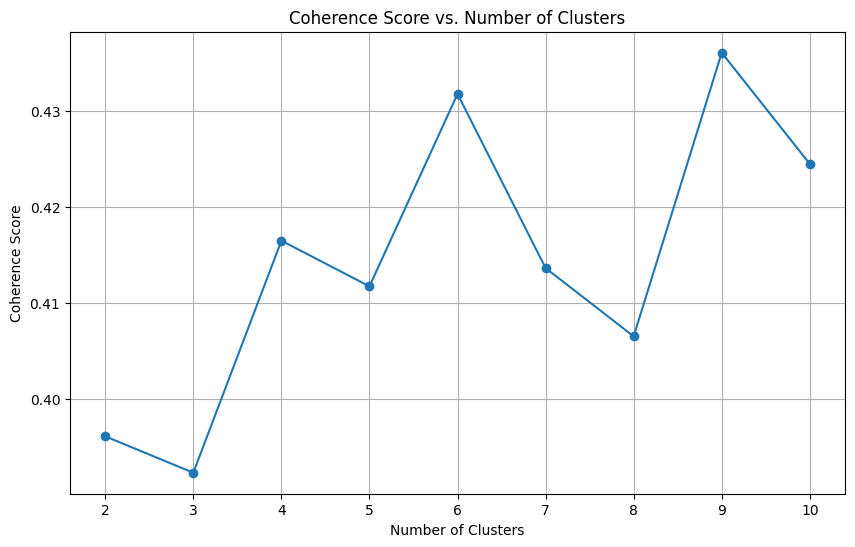

In [ ]:
# Tokenize the cleaned complaints to create the 'texts' list
texts = [doc.split() for doc in processed_df['complaint_cleaned']]

# Proceed with the coherence score calculation
corpus_gensim = gensim.matutils.Sparse2Corpus(X.T)
id_map = dict((v, k) for k, v in tfidf_vect.vocabulary_.items())
dictionary = Dictionary.from_corpus(corpus_gensim, id2word=id_map)

coherence_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    nmf_model_gensim = Nmf(corpus=corpus_gensim, num_topics=n_clusters, id2word=dictionary, passes=5)
    cm = CoherenceModel(model=nmf_model_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(cm.get_coherence())

# Plotting the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, coherence_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Clusters')
plt.grid(True)
plt.show()

Optimal Number of clusters are 6 based on these Coherence scores.

Apply the Best Number to Create Word Clusters

In [ ]:
best_num_clusters = 6  # 5 is the optimal number of clusters from the elbow method

# Fit NMF with the best number of clusters
nmf_model = NMF(n_components=best_num_clusters, random_state=42)
nmf_features = nmf_model.fit_transform(X)

Inspect & Validate Each Cluster with Respect to the Complaints

In [ ]:
# Get the top words in each cluster
def get_top_words_in_cluster(cluster_idx, feature_names, num_top_words=10):
    top_words_idx = nmf_model.components_[cluster_idx].argsort()[:-num_top_words - 1:-1]
    return [feature_names[idx] for idx in top_words_idx]

feature_names = tfidf_vect.get_feature_names_out()

for i in range(best_num_clusters):
    print(f"Cluster {i+1}:")
    top_words = get_top_words_in_cluster(i, feature_names)
    print(top_words)
    print()

Cluster 1:
['account', 'check', 'bank', 'money', 'deposit', 'chase', 'fund', 'branch', 'day', 'transfer']

Cluster 2:
['card', 'credit', 'chase', 'balance', 'account', 'year', 'purchase', 'score', 'limit', 'point']

Cluster 3:
['payment', 'balance', 'month', 'pay', 'statement', 'fee', 'auto', 'day', 'time', 'chase']

Cluster 4:
['report', 'inquiry', 'credit', 'company', 'information', 'reporting', 'debt', 'account', 'identity', 'file']

Cluster 5:
['loan', 'mortgage', 'chase', 'home', 'modification', 'property', 'year', 'letter', 'rate', 'document']

Cluster 6:
['charge', 'dispute', 'fee', 'transaction', 'chase', 'merchant', 'claim', 'refund', 'purchase', 'fraud']



Based on these Clusters, And Top words in each cluster, we will define the following topics to clusters:

- Cluster 1: Bank account services
- Cluster 2: Credit card / Prepaid card
- Cluster 3: Payment Services
- Cluster 4: Others
- Cluster 5: Mortgages/loans
- Cluster 6: Theft/Dispute

In [ ]:
processed_df['Cluster'] = nmf_model.transform(X).argmax(axis=1)

In [ ]:
topic_mapping = {
    0: 'Bank account services',
    1: 'Credit card / Prepaid card',
    2: 'Payment Services',
    3: 'Others',
    4: 'Mortgages/loans',
    5: 'Theft/Dispute'
}


In [ ]:
processed_df['Topic'] = processed_df['Cluster'].map(topic_mapping)

In [ ]:
#assign clusters
processed_df.head()

complaint_processed  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services  \nin   i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable  i am asking the bank to validate the debt  instead i been receiving mail every month from them attempting to collect a debt  \ni have a right to know this information as a consumer  \n\nchase account   xxxx xxxx xxxx xxxx thanks in advance for your help   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       i upgraded my xxxx xxxx card in xx xx   and was told by the agent who did the upgrade my anniversary date would not change  it turned the agent was giving me the wrong information in order to upgrade the account  xxxx   changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent  xxxx has the recording of the agent who was misled me   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### **Supervised Machine Learning for Further Future Complaints Classification**

In [ ]:
data = processed_df[['complaint_processed','Cluster']]

In [ ]:
data.head()

complaint_processed  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services  \nin   i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable  i am asking the bank to validate the debt  instead i been receiving mail every month from them attempting to collect a debt  \ni have a right to know this information as a consumer  \n\nchase account   xxxx xxxx xxxx xxxx thanks in advance for your help   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       i upgraded my xxxx xxxx card in xx xx   and was told by the agent who did the upgrade my anniversary date would not change  it turned the agent was giving me the wrong information in order to upgrade the account  xxxx   changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent  xxxx has the recording of the agent who was misled me   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
X = data['complaint_processed']
y = data['Cluster']


In [ ]:
# Convert the target variable into categorical
y = pd.Categorical(y).codes

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
#functio to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##function to train and evaluate a model
def train_eval_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, predictions))

    # Plotting confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure()
    plot_confusion_matrix(cm, classes=np.unique(y))
    plt.show()

    # Plotting ROC Curve
    y_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_bin.shape[1]
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      1021
           1       0.84      0.89      0.86       868
           2       0.91      0.82      0.86       476
           3       0.90      0.81      0.85       436
           4       0.89      0.88      0.89       753
           5       0.85      0.77      0.81       661

    accuracy                           0.86      4215
   macro avg       0.87      0.85      0.86      4215
weighted avg       0.86      0.86      0.86      4215



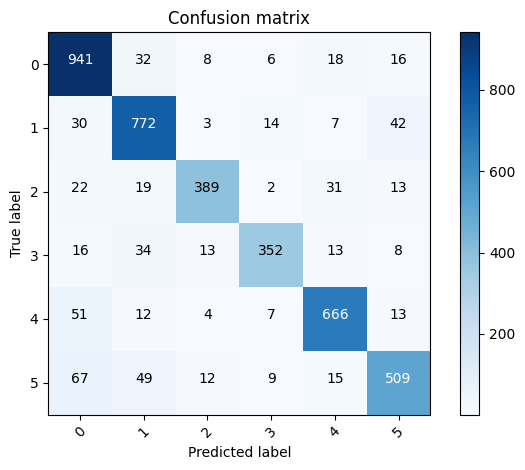

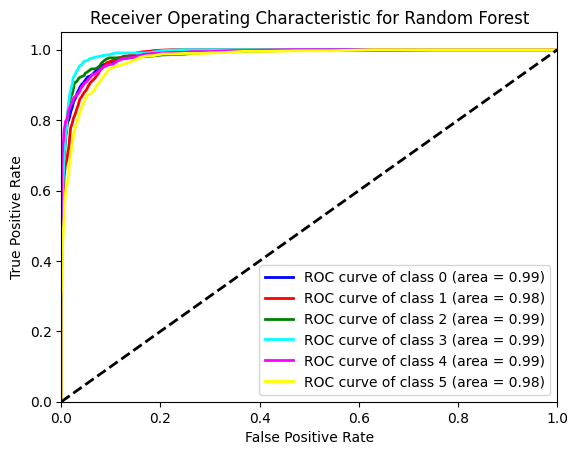

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
train_eval_model(rf_model, "Random Forest", X_train, y_train, X_test, y_test)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1021
           1       0.93      0.92      0.93       868
           2       0.94      0.88      0.91       476
           3       0.91      0.88      0.90       436
           4       0.92      0.91      0.92       753
           5       0.91      0.89      0.90       661

    accuracy                           0.92      4215
   macro avg       0.92      0.91      0.91      4215
weighted avg       0.92      0.92      0.92      4215



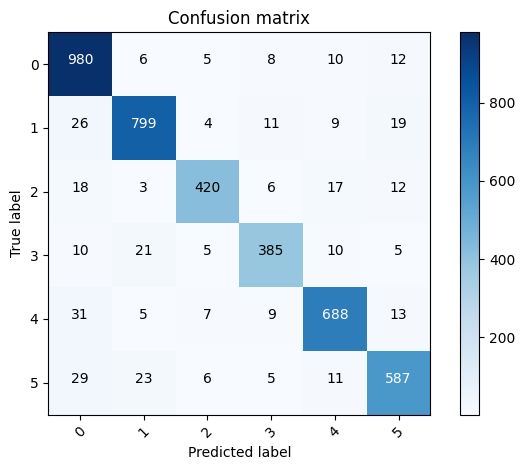

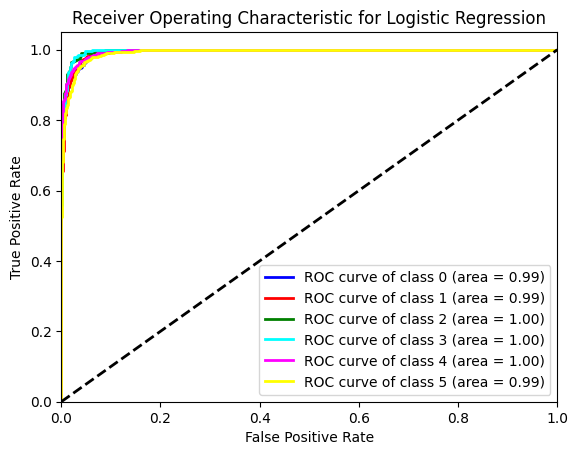

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
train_eval_model(lr_model, "Logistic Regression", X_train, y_train, X_test, y_test)

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1021
           1       0.90      0.92      0.91       868
           2       0.91      0.91      0.91       476
           3       0.90      0.86      0.88       436
           4       0.92      0.89      0.91       753
           5       0.87      0.84      0.86       661

    accuracy                           0.90      4215
   macro avg       0.90      0.89      0.89      4215
weighted avg       0.90      0.90      0.90      4215



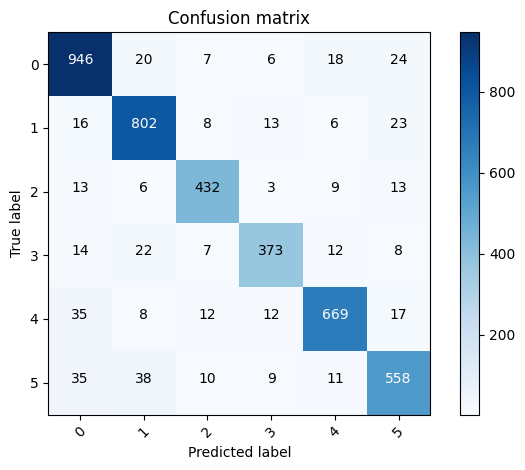

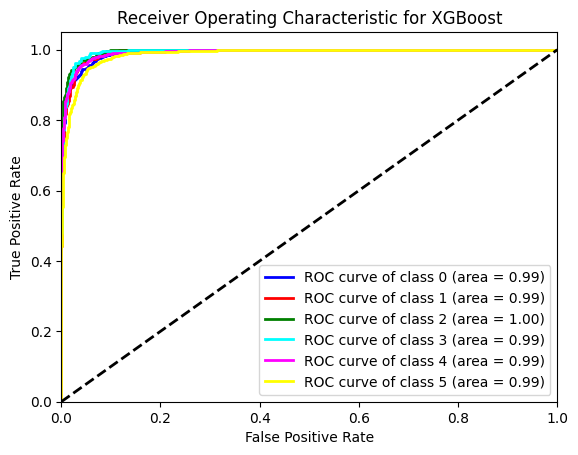

In [ ]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
train_eval_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test)